In [1]:
import os
import seaborn as sns
import torch

from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor, TQDMProgressBar
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.utilities.model_summary import ModelSummary
from lightning.pytorch import seed_everything

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
torch.set_float32_matmul_precision('high')

In [4]:
%load_ext autoreload

In [5]:
%autoreload
from cellnet.estimators import EstimatorCellTypeClassifier

/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")


# Init model

In [6]:
# config parameters
MODEL = 'cellnet_simple'
CHECKPOINT_PATH = os.path.join('/mnt/dssfs02/tb_logs', MODEL)
LOGS_PATH = os.path.join('/mnt/dssfs02/tb_logs', MODEL)
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_simple_norm_parquet'


estim = EstimatorCellTypeClassifier(DATA_PATH)
seed_everything(1)
estim.init_datamodule(batch_size=2048)
estim.init_trainer(
    trainer_kwargs={
        'max_epochs': 250,
        'gradient_clip_val': 1.,
        'gradient_clip_algorithm': 'norm',
        'default_root_dir': CHECKPOINT_PATH,
        'accelerator': 'gpu',
        'devices': 1,
        'num_sanity_val_steps': 0,
        'check_val_every_n_epoch': 1,
        'logger': [TensorBoardLogger(LOGS_PATH, name='default')],
        'log_every_n_steps': 100,
        'detect_anomaly': False,
        'enable_progress_bar': True,
        'enable_model_summary': False,
        'enable_checkpointing': True,
        'callbacks': [
            TQDMProgressBar(refresh_rate=50),
            LearningRateMonitor(logging_interval='step'),
            ModelCheckpoint(filename='val_f1_macro_{epoch}_{val_f1_macro:.3f}', monitor='val_f1_macro', mode='max',
                            every_n_epochs=1, save_top_k=2),
            ModelCheckpoint(filename='val_loss_{epoch}_{val_loss:.3f}', monitor='val_loss', mode='min',
                            every_n_epochs=1, save_top_k=2)
        ],
    }
)
estim.init_model(
    model_type='tabnet',
    model_kwargs={
        'learning_rate': 0.005,
        'weight_decay': 0.1,
        'lr_scheduler': torch.optim.lr_scheduler.StepLR,
        'lr_scheduler_kwargs': {
            'step_size': 2,
            'gamma': 0.9,
            'verbose': True
        },
        'optimizer': torch.optim.AdamW,
        'lambda_sparse': 1e-5,
        'n_d': 128,
        'n_a': 64,
        'n_steps': 3,
        'gamma': 1.3,
        'n_independent': 5,
        'n_shared': 3,
        'virtual_batch_size': 256,
        'mask_type': 'entmax',
        'augment_training_data': True,
        'correct_targets': False
    },
)
print(ModelSummary(estim.model))


[rank: 0] Global seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | classifier    | TabNet           | 13.0 M
---------------------------------------------------
13.0 M    Trainable params
0         Non-trainable params
13.0 M    Total params
51.870    Total estimated model params size (MB)


# Find learning rate

In [7]:
lr_find_res = estim.find_lr(lr_find_kwargs={'early_stop_threshold': 10., 'min_lr': 1e-8, 'max_lr': 10., 'num_training': 120})

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Adjusting learning rate of group 0 to 5.0000e-03.


Finding best initial lr: 100%|██████████| 120/120 [02:20<00:00,  1.17s/it]
Learning rate set to 0.26607250597988075
Restoring states from the checkpoint path at /mnt/dssfs02/tb_logs/cellnet_simple/.lr_find_adf25835-3398-40af-8d2b-5fd223b6c7b9.ckpt
Restored all states from the checkpoint at /mnt/dssfs02/tb_logs/cellnet_simple/.lr_find_adf25835-3398-40af-8d2b-5fd223b6c7b9.ckpt


Suggested learning rate: 0.26607250597988075


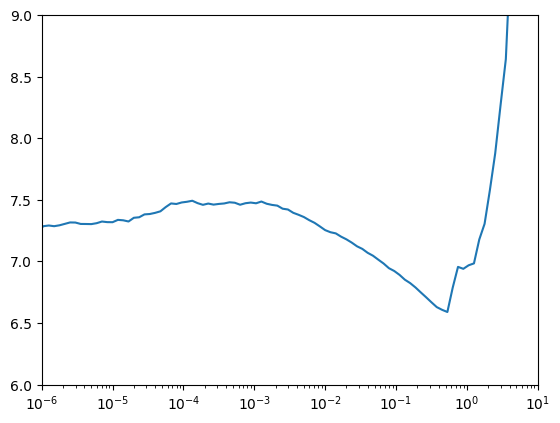

In [8]:
ax = sns.lineplot(x=lr_find_res[1]['lr'], y=lr_find_res[1]['loss'])
ax.set_xscale('log')
ax.set_ylim(6., top=9.)
ax.set_xlim(1e-6, 10.)
print(f'Suggested learning rate: {lr_find_res[0]}')

# Fit model

In [ ]:
estim.train()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Adjusting learning rate of group 0 to 5.0000e-03.
Epoch 0: 100%|██████████| 3238/3238 [26:52<00:00,  2.01it/s, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 3238/3238 [25:15<00:00,  2.14it/s, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 3238/3238 [25:13<00:00,  2.14it/s, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 3238/3238 [25:13<00:00,  2.14it/s, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 3238/3238 [25:13<00:00,  2.14it/s, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 3238/3238 [25:15<00:00,  2.14it/s, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 3238/3238 [25:13<00:00,  2.14it/s, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 3238/3238 [25:13<00:00,  2.14it/s, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 15: 100%|██████████| 3238/3238 [25:18<00:00,  2.13it/s, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 16: 100%|██████████| 3238/3238 [25